In [1]:
"""
Created on August 31 2022

@author: JJ
"""

'\nCreated on August 31 2022\n\n@author: JJ\n'

In [2]:
import os, re, sys
import numpy as np
import pandas as pd
from math import log
import random
import scipy.io
import tensorflow as tf
import csv

2022-10-12 13:55:38.870971: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.regularizers import (
    l2, 
    l1, 
    l1_l2
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import (
    activations, 
    initializers, 
    regularizers, 
    constraints
)

In [4]:
#import from python files
from model import build_model

In [5]:
num_threads = 8
# Maximum number of threads to use for OpenMP parallel regions.
os.environ["OMP_NUM_THREADS"] = "8"
# Without setting below 2 environment variables, it didn't work for me. Thanks to @cjw85 
os.environ["TF_NUM_INTRAOP_THREADS"] = "4"
os.environ["TF_NUM_INTEROP_THREADS"] = "4"

tf.config.threading.set_inter_op_parallelism_threads(
    num_threads
)
tf.config.threading.set_intra_op_parallelism_threads(
    num_threads
)
tf.config.set_soft_device_placement(True)

In [6]:
# in a well-defined initial state.
random.seed(1337)
np.random.seed(1337)
tf.random.set_seed(1337)

In [7]:
import matplotlib
import matplotlib.pyplot as plt

In [8]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint, 
    EarlyStopping
)
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)

In [9]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample, shuffle
from sklearn.feature_selection import (
    SelectKBest,
    chi2
)
import keras_tuner as kt
from collections import defaultdict

In [10]:
all_pep, all_mhc, all_target = np.load('/home/jjia1/jjia1/viralepitope/all_pep_converted.npy'), np.load('/home/jjia1/jjia1/viralepitope/all_mhc_converted.npy'), np.load('/home/jjia1/jjia1/viralepitope/all_target_converted.npy')

In [11]:
def balanced_sampling(pep, mhc, target):
    pos = np.where(target==1)
    neg = np.where(target==0)

    pep_pos, mhc_pos, target_pos = pep[pos], mhc[pos], target[pos]
    pep_neg, mhc_neg, target_neg = pep[neg], mhc[neg], target[neg]

    pep_pos, mhc_pos, target_pos = resample(pep_pos, mhc_pos, target_pos, n_samples= len(target_pos))
    pep_neg, mhc_neg, target_neg = resample(pep_neg, mhc_neg, target_neg, n_samples= len(target_pos))


    pep = np.concatenate([pep_pos, pep_neg])
    mhc = np.concatenate([mhc_pos, mhc_neg])
    target = np.concatenate([target_pos, target_neg])

    pep, mhc, target = shuffle(pep, mhc, target)
    return pep, mhc, target
    

In [12]:
train_pep, test_pep, train_mhc, test_mhc, train_target, test_target = train_test_split(all_pep, all_mhc, all_target, test_size = 0.2, stratify= all_target)

In [13]:
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 5)

In [14]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)    
allprobas_=np.array([]) 
all_labels=np.array([])

In [16]:
for u in range(10):
        pep_bal, mhc_bal, target_bal = balanced_sampling(train_pep, train_mhc, train_target)
        folder = 'model/Ensemble/CV_'+str(u)+'/'
        for i, (train, test) in enumerate(kfold.split(train_pep, train_target)):
                training_pep = train_pep[train]
                training_mhc = train_mhc[train]
                training_target = train_target[train]
                
                validation_pep = train_pep[test]
                validation_mhc = train_mhc[test]
                validation_target = train_target[test]

                mc = ModelCheckpoint(folder+'model_' +str(i)+'.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
                model = build_model(training_pep, training_mhc)
                model.summary()

                model.fit([training_pep,training_mhc], 
                        training_target,
                        batch_size=512,
                        epochs = 100,
                        shuffle=True,
                        callbacks=[es, mc],
                        validation_data=([validation_pep,validation_mhc], validation_target),
                        verbose=1)  
                del model

                saved_model = build_model(training_pep, training_mhc)
                saved_model.load_weights(folder+'model_' +str(i)+'.h5')
                probas_ = saved_model.predict([np.array(validation_pep),np.array(validation_mhc)])
                allprobas_ = np.append(allprobas_, probas_)           
                all_labels = np.append(all_labels, validation_target)
                del saved_model


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-10-11 12:36:03.215232: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-11 12:36:03.216733: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-11 12:36:03.216755: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-11 12:36:03.216780: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sbcphaplp001.uthouston.edu): /proc/driver/nvidia/version does not exist
2022-10-11 12:36:03.217108: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other op

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
peptide (InputLayer)            [(None, 30, 20)]     0                                            
__________________________________________________________________________________________________
mhc (InputLayer)                [(None, 34, 20)]     0                                            
__________________________________________________________________________________________________
conv1_pep (Conv1D)              (None, 30, 128)      7808        peptide[0][0]                    
__________________________________________________________________________________________________
conv1_mhc (Conv1D)              (None, 34, 128)      7808        mhc[0][0]                        
______________________________________________________________________________________________

2022-10-11 12:36:08.485174: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-11 12:36:08.487207: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


Epoch 1/100
1182/1182 [==============================] - 73s 61ms/step - loss: 0.2637 - accuracy: 0.9053 - auc: 0.7783 - val_loss: 0.2124 - val_accuracy: 0.9149 - val_auc: 0.8832

Epoch 00001: val_accuracy improved from -inf to 0.91488, saving model to model/Ensemble/CV_0/model_0.h5
Epoch 2/100
1182/1182 [==============================] - 67s 56ms/step - loss: 0.2167 - accuracy: 0.9131 - auc: 0.8774 - val_loss: 0.2062 - val_accuracy: 0.9159 - val_auc: 0.8913

Epoch 00002: val_accuracy improved from 0.91488 to 0.91593, saving model to model/Ensemble/CV_0/model_0.h5
Epoch 3/100
1182/1182 [==============================] - 62s 52ms/step - loss: 0.2083 - accuracy: 0.9158 - auc: 0.8858 - val_loss: 0.2034 - val_accuracy: 0.9169 - val_auc: 0.8946

Epoch 00003: val_accuracy improved from 0.91593 to 0.91692, saving model to model/Ensemble/CV_0/model_0.h5
Epoch 4/100
1182/1182 [==============================] - 63s 53ms/step - loss: 0.2081 - accuracy: 0.9154 - auc: 0.8883 - val_loss: 0.2041 - va

In [15]:
temp_probas=np.array([]) 
temp_labels=np.array([])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-10-12 13:56:28.826505: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-12 13:56:28.827079: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-12 13:56:28.827095: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-12 13:56:28.827124: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sbcphaplp001.uthouston.edu): /proc/driver/nvidia/version does not exist
2022-10-12 13:56:28.827398: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other op

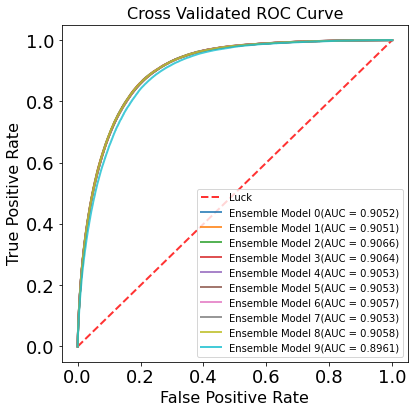

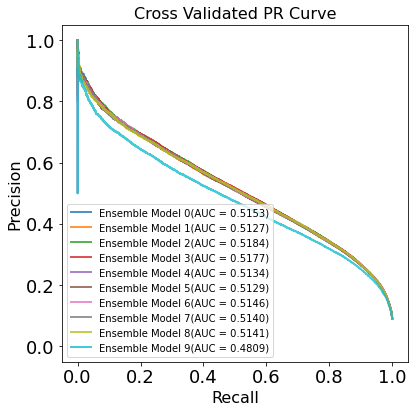

In [16]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

for u in range(10):
    pep_bal, mhc_bal, target_bal = balanced_sampling(train_pep, train_mhc, train_target)
    folder = 'model/Ensemble/CV_'+str(u)+'/'
    for i, (train, test) in enumerate(kfold.split(train_pep, train_target)):
        training_pep = train_pep[train]
        training_mhc = train_mhc[train]
        training_target = train_target[train]
        
        validation_pep = train_pep[test]
        validation_mhc = train_mhc[test]
        validation_target = train_target[test]

        savedmodel = build_model(training_pep, training_mhc)
        savedmodel.load_weights(folder+'model_'+str(i)+'.h5')
        probas_ = savedmodel.predict([np.array(validation_pep),np.array(validation_mhc)])
        del savedmodel
        temp_probas = np.append(temp_probas, probas_)
        temp_labels = np.append(temp_labels, validation_target)

    if u == 0:
        fpr, tpr, threshold = roc_curve(temp_labels, temp_probas)
        auroc = auc(fpr, tpr)
        pr, rc, _ = precision_recall_curve(temp_labels, temp_probas)
        aupr = average_precision_score(temp_labels, temp_probas)

        figure1, ax1 = plt.subplots(figsize=figsize)
        ax1.tick_params(labelsize=18)
        labels = ax1.get_xticklabels() + ax1.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]  
        ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)

        ax1.plot(fpr, tpr,
                label=r'Ensemble Model '+str(u)+ '(AUC = %0.4f)' % (auroc),
                    lw=2, alpha=.8)
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_xlabel('False Positive Rate', font1)
        ax1.set_ylabel('True Positive Rate', font1)
        title1 = 'Cross Validated ROC Curve'
        ax1.set_title(title1, font1)
        ax1.legend(loc="lower right")
        
        ########PR_figure
        figure2, ax2 = plt.subplots(figsize=figsize)
        ax2.tick_params(labelsize=18)
        labels = ax2.get_xticklabels() + ax2.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels] 

        ax2.plot(rc, pr,
                label=r'Ensemble Model '+str(u)+ '(AUC = %0.4f)' % aupr,
                lw=2, alpha=.8)

        ax2.set_xlim([-0.05, 1.05])
        ax2.set_ylim([-0.05, 1.05])
        ax2.set_xlabel('Recall', font1)
        ax2.set_ylabel('Precision', font1)
        title2 = 'Cross Validated PR Curve'
        ax2.set_title(title2, font1)
        ax2.legend(loc="lower left")
    else:
        fpr, tpr, threshold = roc_curve(temp_labels, temp_probas)
        auroc = auc(fpr, tpr)
        pr, rc, _ = precision_recall_curve(temp_labels, temp_probas)
        aupr = average_precision_score(temp_labels, temp_probas)

        ax1.plot(fpr, tpr,
        label=r'Ensemble Model '+str(u)+ '(AUC = %0.4f)' % (auroc),
            lw=2, alpha=.8)
        ax1.legend(loc="lower right")


        ax2.plot(rc, pr,
                label=r'Ensemble Model '+str(u)+ '(AUC = %0.4f)' % aupr,
                lw=2, alpha=.8)
        ax2.legend(loc='lower left')

    allprobas_ = np.append(allprobas_, temp_probas)
    all_labels = np.append(all_labels, temp_labels)

    temp_probas = np.array([])
    temp_labels = np.array([])

In [41]:
figure1.savefig('figures/balancedCV_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')
figure2.savefig('figures/balancedCV_5_fold_prc.jpg', dpi=300, bbox_inches = 'tight')

0.904674343087452


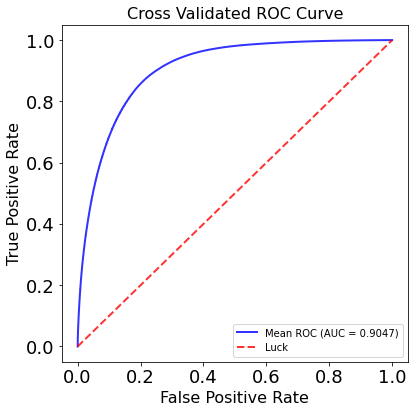

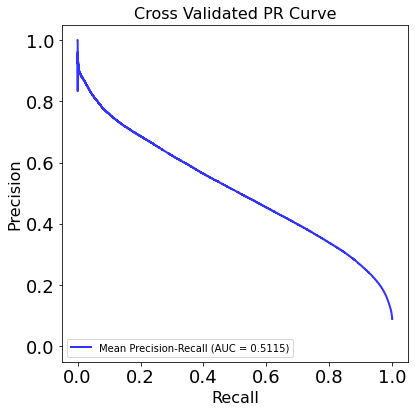

In [17]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

########ROC_figure
figure1, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(labelsize=18)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]  

fpr, tpr, thresholds = roc_curve(all_labels, allprobas_)
roc_auc = auc(fpr, tpr)
print(roc_auc)

ax1.plot(fpr, tpr, color='b',
    label=r'Mean ROC (AUC = %0.4f)' % (roc_auc),
    lw=2, alpha=.8)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate', font1)
ax1.set_ylabel('True Positive Rate', font1)
title1 = 'Cross Validated ROC Curve'
ax1.set_title(title1, font1)
ax1.legend(loc="lower right")
#figure1.savefig('figures/balancedCV_mean_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')

########PR_figure
figure2, ax2 = plt.subplots(figsize=figsize)
ax2.tick_params(labelsize=18)
labels = ax2.get_xticklabels() + ax2.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 

precision, recall, _ = precision_recall_curve(all_labels, allprobas_)
ax2.plot(recall, precision, color='b',
        label=r'Mean Precision-Recall (AUC = %0.4f)' % (average_precision_score(all_labels, allprobas_)),
        lw=2, alpha=.8)

ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('Recall', font1)
ax2.set_ylabel('Precision', font1)
title2 = 'Cross Validated PR Curve'
ax2.set_title(title2, font1)
ax2.legend(loc="lower left")
#figure2.savefig('figures/balancedCV_mean_5_fold_pr.jpg', dpi=300, bbox_inches = 'tight')


In [43]:
allprobas2_=np.array([]) 
all_labels2=np.array([])

0.9043729084154335
0.8867285406173129
0.9078333530003553
0.8913014574605149
0.9069692972279242
0.8901869411617296
0.9065570514645526
0.8886435432412917
0.907325825686799
0.8897905578600386


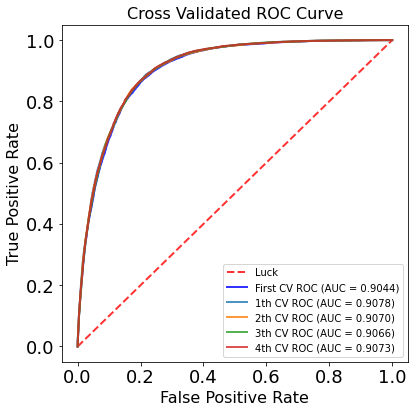

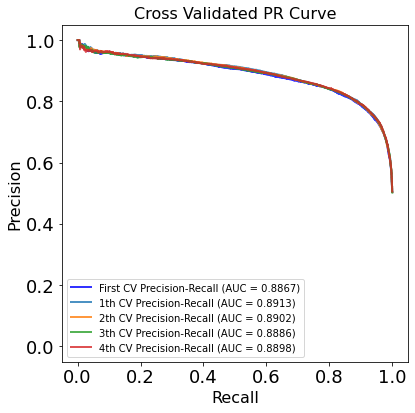

In [44]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

for i in range(5):
    if i == 0:
        saved_model = build_model(training_pep, training_mhc)
        saved_model.load_weights('model/balanced_CV/model_' +str(i)+'.h5')
        probas_ = saved_model.predict([np.array(test_pep),np.array(test_mhc)])
        allprobas2_ = np.append(allprobas2_, probas_)           
        all_labels2 = np.append(all_labels2, test_target)
        del saved_model

        fpr, tpr, thresholds = roc_curve(all_labels2, allprobas2_)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(all_labels2, allprobas2_)
        aupr = average_precision_score(all_labels2, allprobas2_)
        print(roc_auc)
        print(aupr)

        figure1, ax1 = plt.subplots(figsize=figsize)
        ax1.tick_params(labelsize=18)
        labels = ax1.get_xticklabels() + ax1.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]  
        ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)

        ax1.plot(fpr, tpr, color='b',
                label=r'First CV ROC (AUC = %0.4f)' % (roc_auc),
                    lw=2, alpha=.8)
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_xlabel('False Positive Rate', font1)
        ax1.set_ylabel('True Positive Rate', font1)
        title1 = 'Cross Validated ROC Curve'
        ax1.set_title(title1, font1)
        ax1.legend(loc="lower right")
        
        ########PR_figure
        figure2, ax2 = plt.subplots(figsize=figsize)
        ax2.tick_params(labelsize=18)
        labels = ax2.get_xticklabels() + ax2.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels] 

        ax2.plot(recall, precision, color='b',
                label=r'First CV Precision-Recall (AUC = %0.4f)' % aupr,
                lw=2, alpha=.8)

        ax2.set_xlim([-0.05, 1.05])
        ax2.set_ylim([-0.05, 1.05])
        ax2.set_xlabel('Recall', font1)
        ax2.set_ylabel('Precision', font1)
        title2 = 'Cross Validated PR Curve'
        ax2.set_title(title2, font1)
        ax2.legend(loc="lower left")

    else:
        saved_model = build_model(training_pep, training_mhc)
        saved_model.load_weights('model/balanced_CV/model_' +str(i)+'.h5')
        probas_ = saved_model.predict([np.array(test_pep),np.array(test_mhc)])
        allprobas2_ = np.append(allprobas2_, probas_)           
        all_labels2 = np.append(all_labels2, test_target)
        del saved_model
        
        fpr, tpr, thresholds = roc_curve(test_target, probas_)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(test_target, probas_)
        aupr = average_precision_score(test_target, probas_)
        print(roc_auc)
        print(aupr)

        ax1.plot(fpr, tpr,
        label=str(i)+'th CV ROC (AUC = %0.4f)' % (roc_auc),
            lw=2, alpha=.8)
        ax1.legend(loc="lower right")


        ax2.plot(recall, precision, 
        label=str(i)+'th CV Precision-Recall (AUC = %0.4f)' % (aupr),
        lw=2, alpha=.8)
        ax2.legend(loc="lower left")

figure1.savefig('figures/balancedCV_test_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')
figure2.savefig('figures/balancedCV_test_5_fold_prc.jpg', dpi=300, bbox_inches = 'tight')

0.9065181307006668


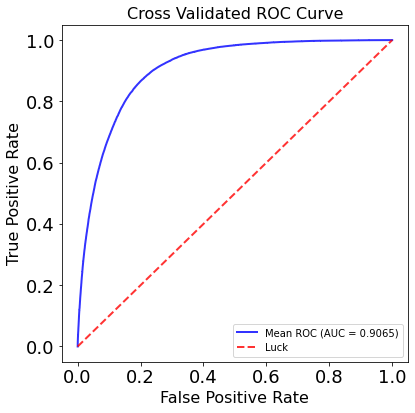

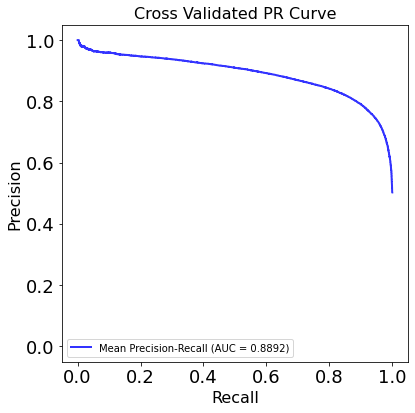

In [45]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

########ROC_figure
figure1, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(labelsize=18)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]  

fpr, tpr, thresholds = roc_curve(all_labels2, allprobas2_)
roc_auc = auc(fpr, tpr)
print(roc_auc)

ax1.plot(fpr, tpr, color='b',
    label=r'Mean ROC (AUC = %0.4f)' % (roc_auc),
    lw=2, alpha=.8)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate', font1)
ax1.set_ylabel('True Positive Rate', font1)
title1 = 'Cross Validated ROC Curve'
ax1.set_title(title1, font1)
ax1.legend(loc="lower right")
figure1.savefig('figures/balancedCV_test_mean_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')

########PR_figure
figure2, ax2 = plt.subplots(figsize=figsize)
ax2.tick_params(labelsize=18)
labels = ax2.get_xticklabels() + ax2.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 

precision, recall, _ = precision_recall_curve(all_labels2, allprobas2_)
ax2.plot(recall, precision, color='b',
        label=r'Mean Precision-Recall (AUC = %0.4f)' % (average_precision_score(all_labels2, allprobas2_)),
        lw=2, alpha=.8)

ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('Recall', font1)
ax2.set_ylabel('Precision', font1)
title2 = 'Cross Validated PR Curve'
ax2.set_title(title2, font1)
ax2.legend(loc="lower left")
figure2.savefig('figures/balancedCV_test_mean_5_fold_pr.jpg', dpi=300, bbox_inches = 'tight')


In [ ]:
figure1, ax1 = plt.subplots(figsize=figsize)
figure2, ax2 = plt.subplots(figsize=figsize)
for i in range(5):
    saved_model = build_model(training_pep, training_mhc)
    saved_model = load_model('model/CV/model_'+str(i)+'.h5')

    ax1.plot(saved_model.history["loss"])
    ax1.plot(saved_model.history["val_loss"])
    ax1.legend(['train', 'test'], loc='best')
 
    ax2.plot(saved_model.history["accuracy"])
    ax2.plot(saved_model.history["val_accuracy"])
    ax2.legend(['train', 'test'], loc='best')

    del saved_model
